In [1]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from tqdm.auto import tqdm
from apyori import apriori
from mlxtend.preprocessing import TransactionEncoder

from Training_Data_Processing import Corner, Kind

os.chdir('C:/Users/user/Desktop/Darui_R08621110')
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

### Preprocessing event data 

In [2]:
def array_f(array_repair):

    ## reorder cols
    cols = array_repair.columns.tolist() #store colnames
    cols = cols[3:4]+cols[1:3] #select id, tool_id(2), dft_mode(7)
    array_repair=array_repair[cols] #discard chip_id, rp_end_time

    ## dummy tool & dft (同一個 ID 中只要有用到就是1 沒有就是0)
    array_repair_dummy = pd.get_dummies(array_repair, columns = ['tool_id', 'dft_mode'])
    array_repair_dummy = array_repair_dummy.groupby(['id']).max().reset_index() #order by id
    
    return array_repair_dummy


def cell_test_f(cell_test):
    
    ## delete the tft_chip_id
    cols = cell_test.columns.tolist()
    cols = cols[-1:] + cols[1:3] 
    cell_test = cell_test[cols] # select id, test_user(1) and grade(7)

    ## dummy test_user & grade
    cell_test_dummy = pd.get_dummies(cell_test, columns = ['test_user', 'grade'])
    cell_test_dummy = cell_test_dummy.groupby(['id']).max().reset_index()
    
    return cell_test_dummy


def cell_repair_f(cell_repair):
    
    # delete the tft_chip_id and reorder
    cell_repair = cell_repair.iloc[:,2:] # discard tft_chip_id & product_code
    cols = cell_repair.columns.tolist()
    cols = cols[-1:] + cols[0:-2] # discard rework_time
    cell_repair = cell_repair[cols] # select id, eqp_id(2) and test_defect_code_desc(33)

    ## dummy eqp_id and test_defect_code_desc
    cell_repair_dummy = pd.get_dummies(cell_repair, columns = ['eqp_id', 'test_defect_code_desc'])
    cell_repair_dummy = cell_repair_dummy.groupby(['id']).max().reset_index()

    return cell_repair_dummy


def risk_db_f(risk_db):
    
    cols = risk_db.columns.tolist()
    cols = cols[-1:] + cols[-2:-1] + cols[0:2] # only reorder
    risk_db = risk_db[cols] # select id, lot_no, event_name(15) and process_stage(4)

    ## dummy stage_event
    risk_db['Stage_Event'] = risk_db['process_stage'].str.cat(risk_db[['event_name']], sep=' - ') # combine two variable
    risk_db = risk_db[['id', 'Stage_Event']] # only keep id and stage_event(16)
    risk_dummy = pd.get_dummies(risk_db, columns = ['Stage_Event'])
    risk_dummy = risk_dummy.groupby(['id']).max().reset_index()
    
    return risk_dummy


def module_f(Module):
    
    cols = Module.columns.tolist()
    cols = cols[2:5]+cols[1:2] # discard lot_no & cell_chip_id
    Module = Module[cols] # select shift_date, id, model_no(17) & GB

    ## dummy model_no
    Module_dummy = pd.get_dummies(Module, columns = ['model_no'])
    Module_dummy = Module_dummy.groupby(['id']).max().reset_index()

    ## reorder
    cols = Module_dummy.columns.tolist()
    cols = cols[3:] + cols[0:3]
    Module_dummy = Module_dummy[cols]
   
    return Module_dummy


def DataSet_Sorted(array_repair, cell_test, cell_repair, risk_db, Module):
    
    #global DataSet
    pd.options.mode.chained_assignment = None
    
    cell_test_dummy = cell_test_f(cell_test)
    cell_repair_dummy = cell_repair_f(cell_repair)
    risk_dummy = risk_db_f(risk_db)
    array_repair_dummy = array_f(array_repair)
    Module_dummy = module_f(Module)
    runhist_array_dummy = runhist_array_f(runhist_array, id_mapping)

    #merge data
    CTC = cell_test_dummy.merge(cell_repair_dummy, how = 'outer', on = 'id')
    CTCR = CTC.merge(risk_dummy, how = 'outer',on = 'id')
    CTCRA = CTCR.merge(array_repair_dummy, how = 'inner',on = 'id')
    DataSet = CTCRA.merge(Module_dummy, how = 'inner', on = 'id').fillna(0)
    
    #drop not unique columns
    cols = DataSet.columns[DataSet.nunique() == 1]
    DataSet = DataSet.drop(cols, axis = 1)
    
    return DataSet

### Dividing train & test data (by date)

In [3]:
def Train_Test(DataSet, y_1 = 2021, m_1 = 1, d_1 = 31, y_2 = 2021, m_2 = 3, d_2 = 31):
    
    data = DataSet.copy()
    
    date = data['shift_date'].str.split("/",expand = True) # divide day, month and year
    date = date.astype(int)
    date.columns = ['month', 'day', 'year']
    DataSet_split = pd.concat([data,date], axis = 1) #combine with original dataframe
    DataSet_split = DataSet_split.drop('shift_date', axis = 1)  
    DataSet_split = DataSet_split.sort_values(by = ['year', 'month', 'day'])
    DataSet_split = DataSet_split.reset_index(drop = True)
    count_1 = DataSet_split[(DataSet_split.year==y_1)&(DataSet_split.month==m_1)&(DataSet_split.day<=d_1)].tail(1).index.item()
    count_2 = DataSet_split[(DataSet_split.year==y_2)&(DataSet_split.month==m_2)&(DataSet_split.day<=d_2)].tail(1).index.item()
    # search for counts of target date interval
    TrainingSet_0 = DataSet_split.iloc[:count_1+1, :-3]
    TestingSet_0 = DataSet_split.iloc[count_1+1:count_2+1, :-3]
    
    return TrainingSet_0, TestingSet_0, DataSet_split


def split_module(module, sep_date = '2021-05-01') :
    
    # define train & test by date in module data
    module_time = order_module(module, drop_time = False)
    
    # define the date
    divide = module_time[module_time['shift_date'] == sep_date].index.min()
    module_train  = module_time.loc[: divide].drop(columns = ['shift_date', 'year', 'month', 'day'])
    module_test = module_time.loc[divide:].drop(columns = ['shift_date', 'year', 'month', 'day']).reset_index(drop = True)
    print('Dimension of unique id in module_train:', module_train.shape,
         '\nDimension of unique id in module_test:', module_test.shape)
    
    return module_train, module_test


def order_module(module, drop_time = True) :
    
    module_drop = module[['id', 'GB', 'shift_date']]
    module_dupli = module_drop.groupby(['id']).max().reset_index()
    date = module_dupli['shift_date'].str.split("-", expand = True)
    date = date.astype(int)
    module_time = pd.concat([module_dupli, date], axis = 1)
    module_time = module_time.rename(columns = {0: 'year', 1: 'month', 2: 'day'})
    module_time = module_time.sort_values(by = ['year', 'month', 'day']).reset_index(drop = True)
    
    if drop_time :
        module_time = module_time.drop(columns = ['month', 'year', 'day'])
        
    return module_time

### Preprocessing runhist data

In [4]:
def runhist_array_m2to7(runhist_array, id_mapping, module, sep_date = '2021-05-01', no_dummy = False) :   

    # transform sheet_id to id
    new_array = runhist_array.merge(id_mapping, on = 'sheet_id', how = 'left')
    new_array = new_array.drop(columns = ['sheet_id', 'create_time', 'lot_no'])
    cols = new_array.columns.tolist()
    cols = cols[2:3] + cols[0:2]
    new_array = new_array[cols]
    
    # combine the carrier features 
    carrier_list = ['ADSPT'+ str(x) for x in list(range(100, 1000, 100))]
    new_array['eqp_split'] = [x.split('_')[0] for x in new_array['eqp_id_info']]

    label_eqp = []
    for i in range(len(new_array)) :
        if new_array['eqp_split'][i] in carrier_list :
            label_eqp.append(new_array['eqp_split'][i])
        else :
            label_eqp.append(new_array['eqp_id_info'][i])

    new_array['label_eqp'] = label_eqp
    array_nodummy = new_array.drop(columns = ['eqp_id_info', 'eqp_split'])

    # one-hot encoding
    if no_dummy == False :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp', 'op_id_info']) 
        #eqp_id_info(124), op_id_info(39)

    elif no_dummy =='eqp' :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['op_id_info'])

    elif no_dummy == 'op' :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp'])
            
    array_done = array_dummy.groupby(['id']).max().reset_index()
    print('Dimension of unique id in runhist_array:', array_done.shape)
    
    # divide train/test & add GB
    module_train, module_test = split_module(module, sep_date)
    array_train = array_done.merge(module_train, on = 'id', how = 'inner')
    array_test = array_done.merge(module_test, on = 'id', how = 'inner').reset_index(drop = True)
    all_array = pd.concat([array_train, array_test]).reset_index(drop = True)
    print('Dimension of unique id in runhist_array_train:', array_train.shape,
         '\nDimension of unique id in runhist_array_test:', array_test.shape)

    return array_train, array_test, all_array


def runhist_array_m8to1(runhist_array, id_mapping, module, no_dummy = False) :
    
    # transform sheet-id to id
    new_array = runhist_array.merge(id_mapping, on = 'sheet_id', how = 'left') # all sheet_id in runhist_array are kept
    col = new_array.columns.tolist()
    col = col[5:6] + col[1:4] # discard lot_no
    new_array = new_array[col]
    
    # combine carrier features
    carrier_list = ['ADSPT'+ str(x) for x in list(range(100, 1000, 100))]
    new_array['eqp_split'] = [x.split('_')[0] for x in new_array['eqp_id_info']]

    label_eqp = []
    for i in range(len(new_array)) :
        if new_array['eqp_split'][i] in carrier_list :
            label_eqp.append(new_array['eqp_split'][i])
        else :
            label_eqp.append(new_array['eqp_id_info'][i])

    new_array['label_eqp'] = label_eqp
    array_nodummy = new_array.drop(columns = ['create_time', 'eqp_id_info', 'eqp_split'])

    # one-hot encoding
    if no_dummy == False :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp', 'op_id_info']) 
        #eqp_id_info(124), op_id_info(39)

    elif no_dummy =='eqp' :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['op_id_info'])

    elif no_dummy == 'op' :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp'])

    array_done = array_dummy.groupby(['id']).max().reset_index()
    
    # merge with module
    module_drop = module[['id', 'GB']]
    module_dupli = module_drop.groupby(['id']).max().reset_index()
    all_array = array_done.merge(module_dupli, on = 'id', how = 'inner')
    print('Dimension of unique id in runhist_array:', all_array.shape)

    return all_array


def runhist_array_old(runhist_array, id_mapping, combine = False):
    
    new_array = runhist_array.merge(id_mapping, on = 'sheet_id', how = 'left') # all sheet_id in runhist_array are kept
    col = new_array.columns.tolist()
    col = col[5:6] + col[1:4] # discard lot_no
    new_array = new_array[col]
    new_array['new_eqp'] = [x.split('_')[0] for x in new_array.eqp_id_info]
    new_array = new_array.drop(columns = ['create_time', 'eqp_id_info'])
    
    if combine == False:
        array_dummy = pd.get_dummies(new_array, columns = ['new_eqp', 'op_id_info']) 
        # eqp_id_info(348/57), op_id_info(54)
        array_dummy = array_dummy.groupby(['id']).max().reset_index()
    
    elif combine == True:
        new_array['op_eqp'] = new_array.op_id_info + '_' + new_array.new_eqp
        pair_array = new_array.drop(columns = ['op_id_info', 'new_eqp'])
        array_dummy = pd.get_dummies(pair_array, columns = ['op_eqp'])
        array_dummy = array_dummy.groupby(['id']).max().reset_index()
    
    return array_dummy 


def runhist_cell_old(runhist_cell, id_mapping) :
    
    new_cell = runhist_cell.merge(id_mapping.iloc[:,1:], on = 'sheet_id', how = 'left') # combine only id
    col = new_cell.columns.tolist()
    col = col[4:5] + col[1:3] # discard sheet_id, create_time
    new_cell = new_cell[col]

    cell_dummy = pd.get_dummies(new_cell, columns = ['eqp_id_info', 'op_id_info'])
    cell_dummy = cell_dummy.groupby(['id']).max().reset_index()
    
    return cell_dummy


def runhist_cell_m2to7(runhist_cell, id_mapping, module, sep_date = '2021-05-01', no_dummy = False) :
    
    # transform sheet_id to id
    id_array = runhist_cell_m2_m5.merge(id_mapping_m2_m5, on = 'sheet_id', how = 'inner')
    reduce_array = id_array.drop(columns = ['sheet_id', 'create_time', 'abbr_cat', 'lot_no'])
    new_array = reduce_array[['id', 'eqp_id_info', 'op_id_info']]

    # transform eqp features
    new_label = new_array['eqp_id_info'].copy()
    table = new_label.str.split('_', expand = True)
    for i in range(len(table)) :

        if table[2][i] in ['COOLING', 'HEATING', 'Cooling', 'Coater Unit', 'Pre Bake No'] :
            new_label[i] = table[0][i] + '_' + table[2][i]        

        elif all([table[2][i] == 'Oven', table[3][i] == 'L']) :
            new_label[i] = table[0][i] + '_Oven_L'

        elif table[3][i] == 'Unit' :
            new_label[i] = table[0][i][:8]

        elif table[3][i] == 'VA' :
            new_label[i] = table[0][i][:8] + table[3][i]

    new_array['label_eqp'] = new_label         
    array_nodummy = new_array.drop(columns = ['eqp_id_info', 'op_id_info'])

    # one-hot encoding
    if no_dummy == False :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp']) # 72
    else :
        array_dummy = array_nodummy

    array_done = array_dummy.groupby(['id']).max().reset_index()
    print('Dimension of unique id in runhist_array:', array_done.shape)

    # divide train/test & add GB
    module_train, module_test = split_module(module, sep_date)
    array_train = array_done.merge(module_train, on = 'id', how = 'inner')
    array_test = array_done.merge(module_test, on = 'id', how = 'inner').reset_index(drop = True)
    all_array = pd.concat([array_train, array_test]).reset_index(drop = True)
    print('Dimension of unique id in runhist_array_train:', array_train.shape,
         '\nDimension of unique id in runhist_array_test:', array_test.shape)

    return array_train, array_test, all_array


def array_cell(train_array, test_array, train_cell, test_cell, module, sep_date = '2021-05-01') :
    
    #merge array & cell
    array_GB = sum(train_array.GB) + sum(test_array.GB)
    cell_GB = sum(train_cell.GB) + sum(test_cell.GB)
    
    if array_GB >= cell_GB :
        join = 'left'
        train_cell = train_cell.drop(columns = ['GB'])
        test_cell = test_cell.drop(columns = ['GB'])
        
    else :
        join = 'right'
        train_array = train_array.drop(columns = ['GB'])
        test_array = test_array.drop(columns = ['GB'])
 
    test_runhist = test_array.merge(test_cell, on = 'id', how = join).fillna(0).reset_index(drop = True)
    train_runhist = train_array.merge(train_cell, on = 'id', how = join).fillna(0).reset_index(drop = True)
    
    # shift GB columns to be the last column
    cols = train_runhist.columns.to_list()
    GB_posi = np.where(train_runhist.columns == 'GB')[0][0]
    new_cols = cols[:GB_posi] + cols[(GB_posi + 1):] + cols[GB_posi:(GB_posi + 1)]
    
    train_runhist = train_runhist[new_cols]
    test_runhist = test_runhist[new_cols]
    
    return train_runhist, test_runhist

In [5]:
def new_shift(old_module) :
    
    old = old_module.copy()
    date = old['shift_date'].str.split('/', expand = True)
    date.columns = ['month', 'day', 'year']
    date['new_shift'] = date['year'] + '-' + date['month'] + '-' + date['day']
    del old['shift_date']
    old['shift_date'] = date['new_shift']
    
    return old


def dataset_index(runhist_target, array_repair, cell_repair, cell_test, risk_db, module) :
    
    outer_temp = cell_repair[['id']].merge(cell_test.id, on = 'id', how = 'outer').groupby('id').max()
    outer = outer_temp.merge(risk_db.id, on = 'id', how = 'outer').groupby('id').max()
    inner_temp = outer.merge(array_repair.id, on = 'id', how = 'inner').groupby('id').max()
    inner = inner_temp.merge(module.id, on = 'id', how = 'inner').groupby('id').max()
    final = runhist_target.merge(inner, on = 'id', how = 'inner')
    
    return final


def feature_filter(train, test) :

    col_train = train.columns.to_list()
    lack_col = [x for x in col_train if x not in test.columns]
    test_temp = test.copy()
    test_temp[lack_col] = 0
    test_final = test_temp[col_train]

    return test_final

### Runhist data plot

In [7]:
##### to see features that actually shows variation in specific month #####
def actual_features(target_array, print_features = True) :
    
    sumup = target_array.iloc[:, 1:-1].apply(sum, axis = 0)
    mask = [sumup != 0][0]
    cols = target_array.iloc[:, 1:-1].columns[mask] 
    
    if print_features :
        for x, y in enumerate(cols) :
            print(x, y)
    
    return cols

##### count the numbers of rework(+) in the features #####
def count_rework(month_cols) :

    eqp_list = []
    op_list = []
    rework_list = []

    for i, name in enumerate(month_cols) :
        split = name.split('_')
        if split[1] == 'eqp' :
            eqp_list.append(name)
        elif '-' in split[3] :
            op_list.append(name)
        elif '+' in split[3] :
            rework_list.append(name)

    print('counts of equipment:', len(eqp_list), 
          '\ncounts of operation:', len(op_list), 
          '\ncounts of rework:', len(rework_list))
    
    return eqp_list, op_list, rework_list

In [8]:
##### plot and compare the feature frequency in good & bad instances #####
def feature_gb(runhist_data, target, figsize = (12, 8)) :    
    allcols = runhist_data.columns.to_list()
    allcols = allcols[1:-1]
    eqp_list, op_list, rework_list = count_rework(allcols)

    if target == 'Equipment' :
        target_list = eqp_list
    elif target == 'Operation' :
        target_list = op_list
    elif target == 'Rework' :
        target_list = rework_list

    feature_frame = runhist_data[target_list]
    feature_good = feature_frame[runhist_data.GB == 0].apply(sum, axis = 0)
    feature_bad = feature_frame[runhist_data.GB == 1].apply(sum, axis = 0)

    bg_ratio = len(feature_frame[runhist_data.GB == 1]) / len(feature_frame[runhist_data.GB == 0])
    good_table = pd.DataFrame({'feature': feature_good.index, 'counts': feature_good.values, 'label': 0})
    bad_table = pd.DataFrame({'feature': feature_bad.index, 'counts': feature_bad.values / bg_ratio, 'label': 1})
    feature_table = pd.concat([good_table, bad_table], axis = 0)

    plt.figure(figsize = figsize)
    sns.set_palette("bright")
    barplot = sns.barplot(y = 'feature', x = 'counts', hue = 'label', data = feature_table)
    barplot.set_title(f'{target} Distribution between Good & Bad Instances')

    return barplot


def feature_distribution(runhist) :   
    
    # select index for label(array), op, label(cell)
    variable_no = [x for x in enumerate(runhist.columns)][1:]
    for i in range(len(variable_no)) :
        if variable_no[i][1][:2] == 'op' :
            index_op = i 
            break
    if variable_no[-1][1][:5] == 'label' :
        for i in range(len(variable_no)) :
            if variable_no[index_op + i][1][:5] == 'label' :
                index_eqp = index_op + i
                break
    
    variables = runhist.iloc[:,1:].drop(columns = 'GB').apply(np.mean, axis = 0)
    eqp1 = variables[:index_op]
    op1 = variables[index_op:index_eqp] if variable_no[-1][1][:5] == 'label' else variables[index_op:]

    fig, axs = plt.subplots(2, 2, figsize = (12, 8), sharex = False)
    fig.suptitle('Features of Runhist Data')
    axs[0, 0].plot(list(range(len(eqp1))), eqp1, 'b.')
    #axs[0, 0].set_xlabel('Feature Index')
    axs[0, 0].set_ylabel('Probability')
    axs[0, 0].set_title('Distribution of label_eqp in array')
    axs[0, 1].plot(list(range(len(op1))), op1, 'r.')
    #axs[0, 1].set_xlabel('Feature Index')
    axs[0, 1].set_ylabel('Probability')
    axs[0, 1].set_title('Distribution of op_id_info in array')
        
    if variable_no[-1][1][:5] == 'label' :
        eqp2 = variables[index_eqp:]
        axs[1, 0].plot(list(range(len(eqp2))), eqp2, 'g.')
        axs[1, 0].set_xlabel('Feature Index')
        axs[1, 0].set_ylabel('Probability')
        axs[1, 0].set_title('Distribution of label_eqp in cell')
        axs[1, 1].plot(list(range(len(variables))), variables, 'y.')
        axs[1, 1].set_xlabel('Feature Index')
        axs[1, 1].set_ylabel('Probability')
        axs[1, 1].set_title('Distribution of All Features')
    
    
def distance_histogram(runhist, bin1, bin2) :    
    
    good = runhist[runhist.GB == 0].drop(columns = ['id', 'GB'])
    bad = runhist[runhist.GB == 1].drop(columns = ['id', 'GB'])
    good = np.array(good)
    bad = np.array(bad)

    gb_matrix = (bad[:, None, :] != good).sum(2)
    bb_matrix = (bad[:, None, :] != bad).sum(2)

    fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))
    ax = sns.histplot(gb_matrix.flatten(), bins = bin1, color = 'purple', ax = axs[0])
    ax.set(title = 'Distribution of Distance between Good & Bad Instances', xlabel = 'Hamming Distance')
    ax = sns.histplot(bb_matrix.flatten(), bins = bin2, color = 'red', ax = axs[1])
    ax.set(title = 'Distribution of Distance between Bad Instances', xlabel = 'Hamming Distance')
    
    
def distance_heatmap(runhist, bad_in_month) :    
    
    good = runhist[runhist.GB == 0].drop(columns = ['id', 'GB'])
    bad = runhist[runhist.GB == 1].drop(columns = ['id', 'GB'])
    good = np.array(good)
    bad = np.array(bad)

    dis_matrix = (bad[:, None, :] != bad).sum(2)

    sns.set(rc = {'figure.figsize':(10,8)})
    sns.color_palette("vlag", as_cmap = True)
    ax = sns.heatmap(dis_matrix, cmap = 'vlag')
    cumsum = list(np.cumsum(bad_in_month))
    ax.hlines(cumsum, *ax.get_xlim(), color = 'black', linewidth = 0.6)
    ax.vlines(cumsum, *ax.get_xlim(), color = 'black', linewidth = 0.6)

### Viewing bad data
1. number of bad types, mean of each type, data counts in each type (in 'Bad_Types')
2. record all variable-combination of bad types (in 'Bad')
3. print out the id of all bad types in each month 

In [9]:
def Balance_Ratio(data, label = 'GB', n = 5):
    
    r = len(data[data[label] == 0]) / len(data[data[label] == 1])
    r = np.around(r, decimals = n)
    
    return r


def Bad_Type_def(DataSet_All, label = 'GB'):
    
    Data = DataSet_All.copy()
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x:'_'.join(x.astype(str)), axis = 1) #join all the variable into a string
    Data[f'{label}_mean'] = Data.groupby('cb')[label].transform('mean') 
    #calculate mean of GB based on 'cb' variable each data possesses
    Data[f'{label}_count'] = Data.groupby('cb')[label].transform('count') # calculate data numbers share the same 'cb' variable
    Data['Bad_count'] = Data.groupby('cb')[label].transform('sum') # calculate #bad data (baesd on GB) 
    All_Bad = Data[Data[label] == 1]
    print('Number of Bad:', len(All_Bad))
    All_Bad = All_Bad.sort_values(['Bad_count', f'{label}_mean'], ascending = [False, False])
    Bad_Types = All_Bad.drop_duplicates(subset = 'cb')
    Bad_Types = Bad_Types[['cb', f'{label}_mean', 'Bad_count']].reset_index(drop = True) 
    # bad type number based on how many kinds of'cb' 
    print('Types of Bad:', len(Bad_Types), '\n')
    
    return Bad_Types


def TypeOfBad(df, Bad_Types, sorting = True, label = 'GB'):
    
    Set_Bad = df[df[label] == 1]
    Bad = []
    for j in range(len(Set_Bad)):
        Key = Set_Bad.iloc[:, 1:-1].apply(lambda x:'_'.join(x.astype(str)),axis = 1) # concatenate variables as a string
        index = Bad_Types[Bad_Types['cb'] == Key.values[j]].index.item()
        Bad.append(index)
        if sorting: 
            Bad.sort() # sorting = True

    print('Types of Bad :\n',Bad,'\n')
    
    return Bad

    
def Bad_Type_by_Time(DataSet_split, Bad_Types, label = 'GB'):
    
    data = DataSet_split
    
    TimeSeries = data.sort_values(['year', 'month', 'day']) ## BAD ID of each month
    for i in TimeSeries['month'].unique():

        print('Month',i,':\n')
        TS = TimeSeries[TimeSeries.month == i].iloc[:, :-3] #exclude day, month and year
        TypeOfBad(TS, Bad_Types, sorting = False, label = label) # view id of bad type in each month

## Data Processing
1. read 7 raw data
2. combine 7 dataframe 
3. split training & testing data by specific date  
4. view variables in runhist_array
5. identify bad data

In [10]:
##### event data######
module = pd.read_csv("event/Module_all.csv").iloc[:,1:]
risk_db = pd.read_csv("event/risk_db_all.csv").iloc[:,1:]
array_repair = pd.read_csv("event/array_repair_all.csv").iloc[:,1:]
cell_repair = pd.read_csv("event/cell_repair_all.csv").iloc[:,1:]
cell_test = pd.read_csv("event/cell_test_all.csv").iloc[:,1:]
DataSet = pd.read_csv("event/DataSet.csv").iloc[:,1:]
print('DataSet:', DataSet.shape)

array_repair_m23 = pd.read_csv('event/data_m2m3/array_repair.csv')
array_repair_m45 = pd.read_csv('event/data_m4m5/array_repair.csv')
array_repair_m67 = pd.read_csv('event/data_m6m7/array_repair.csv')
array_repair_m2_m7 = pd.concat([array_repair_m23, array_repair_m45, array_repair_m67])
cell_repair_m23 = pd.read_csv('event/data_m2m3/cell_repair.csv')
cell_repair_m45 = pd.read_csv('event/data_m4m5/cell_repair.csv')
cell_repair_m67 = pd.read_csv('event/data_m6m7/cell_repair.csv')
cell_repair_m2_m7 = pd.concat([cell_repair_m23, cell_repair_m45, cell_repair_m67])
cell_test_m23 = pd.read_csv('event/data_m2m3/cell_test.csv')
cell_test_m45 = pd.read_csv('event/data_m4m5/cell_test.csv')
cell_test_m67 = pd.read_csv('event/data_m6m7/cell_test.csv')
cell_test_m2_m7 = pd.concat([cell_test_m23, cell_test_m45, cell_test_m67])
risk_db_m23 = pd.read_csv('event/data_m2m3/risk_db.csv')
risk_db_m45 = pd.read_csv('event/data_m4m5/risk_db.csv')
risk_db_m67 = pd.read_csv('event/data_m6m7/risk_db.csv')
risk_db_m2_m7 = pd.concat([risk_db_m23, risk_db_m45, risk_db_m67])
module_m23 = pd.read_csv('event/data_m2m3/module.csv')
module_m45 = pd.read_csv('event/data_m4m5/module.csv')
module_m67 = pd.read_csv('event/data_m6m7/module.csv')
module_m2_m7 = pd.concat([module_m23, module_m45, module_m67])

##### runhist data #####
runhist_array_m1 = pd.read_csv('ARRAY_RunHist/runhist_array_m1.csv')
runhist_array_m2 = pd.read_csv('ARRAY_RunHist/runhist_array_m2m3.csv')
runhist_array_m8 = pd.read_csv('ARRAY_RunHist/runhist_array_m8m9m10m11.csv')
runhist_array_m12 = pd.read_csv('ARRAY_RunHist/runhist_array_m12.csv')
runhist_array_m8_m1 = pd.concat([runhist_array_m8, runhist_array_m12, runhist_array_m1])
runhist_array_m23 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m2m3/runhist_array.csv')
runhist_array_m45 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m4m5/runhist_array.csv')
runhist_array_m67 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m6m7/runhist_array.csv')
runhist_array_m2_m7 = pd.concat([runhist_array_m23, runhist_array_m45, runhist_array_m67])
id_mapping_m23 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m2m3/id_mapping.csv')
id_mapping_m45 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m4m5/id_mapping.csv')
id_mapping_m67 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m6m7/id_mapping.csv')
id_mapping_m2_m7 = pd.concat([id_mapping_m23, id_mapping_m45, id_mapping_m67])
id_mapping_m1 = pd.read_csv('ARRAY_RunHist/id_mapping_m1.csv')
id_mapping_m2 = pd.read_csv('ARRAY_RunHist/id_mapping_m2m3.csv')
id_mapping_m8 = pd.read_csv('ARRAY_RunHist/id_mapping_m8m9m10m11.csv')
id_mapping_m12 = pd.read_csv('ARRAY_RunHist/id_mapping_m12.csv')
id_mapping_m8_m1 = pd.concat([id_mapping_m8, id_mapping_m12, id_mapping_m1])
runhist_cell_m1 = pd.read_csv('ARRAY_RunHist/runhist_cell_m1.csv')
runhist_cell_m2 = pd.read_csv('ARRAY_RunHist/runhist_cell_m2m3.csv')
runhist_cell_m8 = pd.read_csv('ARRAY_RunHist/runhist_cell_m8m9m10m11.csv')
runhist_cell_m12 = pd.read_csv('ARRAY_RunHist/runhist_cell_m12.csv')
runhist_cell_m8_m1 = pd.concat([runhist_cell_m8, runhist_cell_m12, runhist_cell_m1])
runhist_cell_m23 = pd.read_csv('ARRAY_RunHist/data_runhist_cell_m2m3/runhist_cell.csv')
runhist_cell_m45 = pd.read_csv('ARRAY_RunHist/data_runhist_cell_m4m5/runhist_cell_m4m5.csv')
runhist_cell_m67 = pd.read_csv('ARRAY_RunHist/data_runhist_cell_m6m7/runhist_cell.csv')
runhist_cell_m2_m7 = pd.concat([runhist_cell_m23, runhist_cell_m45, runhist_cell_m67])

runhist_cell_boru = pd.read_csv('ARRAY_RunHist/binary_encoding_RunHistoryCell_label.csv').iloc[:, :76]
print('\nrunhist_cell_boru:', runhist_cell_boru.shape, '\n')

##### dimension of all the dataframes ######
print('Array_repair_m8_m3:', array_repair.shape,
      '\nCell_test_m8_m3:',cell_test.shape, 
      '\nCell_repair_m8_m3:', cell_repair.shape, 
      '\nRisk_db_m8_m3:', risk_db.shape, 
      '\nModule_m8_m3:', module.shape, 
      '\nModule_m2_m7:', module_m2_m7.shape, 
      '\nRunhist_array_m8_m1:', runhist_array_m8_m1.shape,
      '\nRunhist_array_m2_m7:', runhist_array_m2_m7.shape,
      '\nID_mapping_m8_m1:', id_mapping_m8_m1.shape, 
      '\nID_mapping_m2_m7:', id_mapping_m2_m7.shape, 
      '\nRunhist_cell_m8_m1:', runhist_cell_m8_m1.shape,
      '\nRunhist_cell_m2_m7:', runhist_cell_m2_m7.shape
)

DataSet: (136298, 84)

runhist_cell_boru: (133600, 76) 

Array_repair_m8_m3: (610816, 5) 
Cell_test_m8_m3: (388895, 4) 
Cell_repair_m8_m3: (10854, 6) 
Risk_db_m8_m3: (582277, 4) 
Module_m8_m3: (212958, 6) 
Module_m2_m7: (278282, 6) 
Runhist_array_m8_m1: (1767053, 4) 
Runhist_array_m2_m7: (3286465, 4) 
ID_mapping_m8_m1: (120289, 3) 
ID_mapping_m2_m7: (278282, 3) 
Runhist_cell_m8_m1: (1505312, 4) 
Runhist_cell_m2_m7: (2943513, 5)


### Event data

In [ ]:
##### merge 5 dataframes #####
DataSet = DataSet_Sorted(array_repair, cell_test, cell_repair, risk_db, Module, id_mapping, runhist_array)
print('Dimension of Merged Data:', DataSet.shape, '\nBR:', Balance_Ratio(DataSet))
DataSet_All = DataSet.copy()
DataSet_All = DataSet_All.drop('shift_date', axis = 1)

In [ ]:
##### output the event data #####
TrainingSet_0, TestingSet_0, DataSet_split = Train_Test(DataSet)
print('TrainingSet_0:', TrainingSet_0.shape, ', Balance Ratio:', Balance_Ratio(TrainingSet_0), \
      '\nTestingSet_0:', TestingSet_0.shape, ', Balance Ratio:', Balance_Ratio(TestingSet_0),'\n')

DataSet = pd.concat([TrainingSet_0, TestingSet_0])
DataSet.to_csv('DataSet.csv')
TrainingSet_0.to_csv('TrainingSet_0.csv')
TestingSet_0.to_csv('TestingSet_0.csv')

In [ ]:
##### output bad types #####
Bad_Types = Bad_Type_def(DataSet_All)
Bad_Types.to_csv('Bad_Types.csv')

Bad_Type_by_Time(DataSet_split, Bad_Types)
print('\nTrainingSet:')
train_bad = TypeOfBad(TrainingSet_0, Bad_Types, sorting = True)
print('\nTestingSet:')
test_bad = TypeOfBad(TestingSet_0, Bad_Types, sorting = True)

### Runhist data

#### Feature infos in each month

In [11]:
##### split the runhist data to one-month #####
# count list of m8 - m1 = [0, 22817, 44206, 62346, 81380, 101997, 119545, _]
# count list of m2 - m7 = [0, 39193, 100305, 160099, 210932, 220610]
old_module = new_shift(module)
old_module = order_module(old_module)
new_module = order_module(module_m2_m7)

module_m8 = old_module.loc[:22817]
module_m9 = old_module.loc[22817:44206]
module_m10 = old_module.loc[44206:62346]
module_m11 = old_module.loc[62346:81380]
module_m12 = old_module.loc[81380:101997]
module_m1 = old_module.loc[101997:119545]

array_m8, _, _ = runhist_array_m2to7(runhist_array_m8, id_mapping_m8, module_m8, sep_date = '2020-9-1')
array_m9, _, _ = runhist_array_m2to7(runhist_array_m8, id_mapping_m8, module_m9, sep_date = '2020-10-1')
array_m10, _, _ = runhist_array_m2to7(runhist_array_m8, id_mapping_m8, module_m10, sep_date = '2020-11-1')
array_m11, _, _ = runhist_array_m2to7(runhist_array_m8, id_mapping_m8, module_m11, sep_date = '2020-12-1')
array_m12, _, _ = runhist_array_m2to7(runhist_array_m12, id_mapping_m12, module_m12, sep_date = '2020-1-1')
array_m1, _, _ = runhist_array_m2to7(runhist_array_m1, id_mapping_m1, module_m1, sep_date = '2021-2-1')

array_m2, array_m3, _ = runhist_array_m2to7(runhist_array_m23, id_mapping_m23, module_m23, sep_date = '2021-03-01')
array_m4, array_m5, _ = runhist_array_m2to7(runhist_array_m45, id_mapping_m45, module_m45, sep_date = '2021-05-01')
array_m6, array_m7, _ = runhist_array_m2to7(runhist_array_m67, id_mapping_m67, module_m67, sep_date = '2021-07-01')

# combine all the data and switch the label to the right end
# array_all = pd.concat([array_m8, array_m9, array_m10, array_m11, array_m12, array_m1, 
#                        array_m2, array_m3, array_m4, array_m5, array_m6, array_m7], axis = 0).fillna(0)

array_train = pd.concat([array_m2, array_m3, array_m4], axis = 0).fillna(0)
col_GB = array_train.GB
array_train = array_train.drop(columns = 'GB')
array_train['GB'] = col_GB
array_test = array_m5.copy()
array_all = pd.concat([array_train, array_test], axis = 0).fillna(0)

Dimension of unique id in runhist_array: (81925, 175)
Dimension of unique id in module_train: (22818, 2) 
Dimension of unique id in module_test: (1, 2)
Dimension of unique id in runhist_array_train: (22818, 176) 
Dimension of unique id in runhist_array_test: (1, 176)
Dimension of unique id in runhist_array: (81925, 175)
Dimension of unique id in module_train: (21390, 2) 
Dimension of unique id in module_test: (1, 2)
Dimension of unique id in runhist_array_train: (21390, 176) 
Dimension of unique id in runhist_array_test: (1, 176)
Dimension of unique id in runhist_array: (81925, 175)
Dimension of unique id in module_train: (18141, 2) 
Dimension of unique id in module_test: (1, 2)
Dimension of unique id in runhist_array_train: (18141, 176) 
Dimension of unique id in runhist_array_test: (1, 176)
Dimension of unique id in runhist_array: (81925, 175)
Dimension of unique id in module_train: (19035, 2) 
Dimension of unique id in module_test: (1, 2)
Dimension of unique id in runhist_array_trai

In [262]:
##### feature selection #####
### by category (drop op with not much difference between good & bad instances) ###
features = array_train.columns[1:-1]
_, op_features, _ = count_rework(features)

br_ratio = sum(array_train.GB == 0) / sum(array_train.GB == 1)
tolerate = 10
for i in op_features:
    bad_count = sum((array_train[i] == 1)&(array_train.GB == 1))
    good_count = sum((array_train[i] == 1)&(array_train.GB == 0))
    ratio = (bad_count*br_ratio) / good_count
    if any([ratio >= tolerate, ratio <= 1/tolerate]):
        op_features.remove(i)

array_train = array_train.drop(columns = op_features)
print(f'Drop {len(op_features)} operation features.\n')

### by variation (drop eqp & rework without variation in the whole instances) ###
features = array_train.columns[1:-1]
sumup = array_train[features].astype(int).apply(sum, axis = 0)
no_variation = []
for i in range(len(sumup)):
    if sumup[i] == 0:
        no_variation.append(features[i])
        array_train = array_train.drop(columns = features[i])
        print(f'Drop \"{features[i]}\"')
print(f'Drop {len(no_variation)} feature(s) with no variation.\n')

### by label (drop eqp & rework with no bad instance involved) ###
features = array_train.columns[1:-1]
no_label = []
for i in features:
    if sum(array_train[i]*array_train.GB) == 0:
        no_label.append(i)
        array_train = array_train.drop(columns = i)
        print(f'Drop \"{i}\"')
print(f'Drop {len(no_label)} feature(s) with no bad label.\n')

### by apriori ###
pass

### by train test split ###
array_test = feature_filter(array_train, array_test)

counts of equipment: 123 
counts of operation: 23 
counts of rework: 15
Drop 20 operation features.

Drop "op_id_info_GL+STOR"
Drop 1 feature(s) with no variation.

Drop "label_eqp_ADAGX300"
Drop "label_eqp_ADAGX400"
Drop "label_eqp_ADCVD100"
Drop "label_eqp_ADCVD300"
Drop "label_eqp_ADCVD600"
Drop "label_eqp_ADCVD800"
Drop "label_eqp_ADCVD900"
Drop "label_eqp_ADCVDB00_D"
Drop "label_eqp_ADRIE100"
Drop "label_eqp_ADRIE200"
Drop "label_eqp_ADRIE300"
Drop "label_eqp_ADRIE400"
Drop "label_eqp_ADRIE500"
Drop "label_eqp_ADRIE600"
Drop "label_eqp_ADRIEA00_1"
Drop "label_eqp_ADRIEA00_2"
Drop "label_eqp_ADRIEA00_3"
Drop "op_id_info_AS+STO"
Drop "op_id_info_GL+CLA"
Drop "op_id_info_GL+IEX"
Drop "op_id_info_TH+IEX"
Drop "op_id_info_TH+STO"
Drop "op_id_info_TH+STO2"
Drop 23 feature(s) with no bad label.



#### runhist array

In [ ]:
##### combine runhist array m8m1 & m2m7 #####
# preprocessing m8 - m1
array_m8_m1 = runhist_array_m8to1(runhist_array_m8_m1, id_mapping_m8_m1, module, no_dummy = False)

array_m2_m4, array_m5_m7, array_m2_m7 = runhist_array_m2to7(runhist_array_m2_m7, id_mapping_m2_m7, module_m2_m7, 
                                                         sep_date = '2021-05-01', no_dummy = False)

# preprocessing m2 - m3, m4 -m5, m6 -m7 individually 
array_m2, array_m3, array_m2_m3 = runhist_array_m2to7(runhist_array_m23, id_mapping_m23, module_m23, 
                                                      sep_date = '2021-03-01', no_dummy = False)
array_m4, array_m5, array_m4_m5 = runhist_array_m2to7(runhist_array_m45, id_mapping_m45, module_m45, 
                                                      sep_date = '2021-05-01', no_dummy = False)
array_m6, array_m7, array_m6_m7 = runhist_array_m2to7(runhist_array_m67, id_mapping_m67, module_m67, 
                                                      sep_date = '2021-07-01', no_dummy = False)


##### only keep the instances exist in event data #####
#it means every id must present in module & array_repair, and at least exist once in cell_repair, cell_test or risk_db
train_m81_dset = dataset_index(array_m8_m1, array_repair, cell_repair, cell_test, risk_db, module)
test_m23_dset = dataset_index(array_m2_m3, array_repair_m23, cell_repair_m23, cell_test_m23, risk_db_m23, module_m23) 
test_m45_dset = dataset_index(array_m4_m5, array_repair_m45, cell_repair_m45, cell_test_m45, risk_db_m45, module_m45)
test_m67_dset = dataset_index(array_m6_m7, array_repair_m67, cell_repair_m67, cell_test_m67, risk_db_m67, module_m67)

In [17]:
##### only keep the equipment & operation id info exist in training data #####
train_array = dataset_index(array_m8_m1, array_repair, cell_repair, cell_test, risk_db, module)
test_array = feature_filter(array_m8_m1, new_dset)

all_runhist = pd.concat([train_array, test_array], axis = 0).reset_index(drop = True)

In [20]:
##### select equipment / operation / rework features #####
##### discard operations without rework #####
feature_m81 = train_array.columns.to_list()[1:-1]
eqp_m81, op_m81, rework_m81 = count_rework(feature_m81)
keep_feature = ['id'] + eqp_m81 + rework_m81 + ['GB']

train_final = train_array[keep_feature]
test_final = test_array[keep_feature]
all_runhist = pd.concat([train_final, test_final], axis = 0).reset_index(drop = True)

train_final.to_csv('train_runhist.csv')
test_final.to_csv('test_runhist.csv')

counts of equipment: 121 
counts of operation: 35 
counts of rework: 19


In [ ]:
########## for whole-year data combination only ##########
##### split runhist array data of whole year in to training & testing #####
# first combine m23 & m4 as part of training data
array_m2_m4 = pd.concat([array_m2_m3, array_m4], axis = 0).fillna(0)

# put the order of columns right (id => cols in m81 => cols only in m24 => GB) 
col_m81 = array_m8_m1.columns.to_list()
m81_lack = [x for x in array_m2_m4.columns if x not in col_m81]
combine_col = col_m81[:-1] + m81_lack + col_m81[-1:]

# combine training data (m8m1 + m2m4)
train_combine = pd.concat([array_m8_m1, array_m2_m4], axis = 0).fillna(0)
train_sort = train_combine[combine_col]
train_uni = train_sort.groupby('id').max().reset_index()

# find cols exist in training data but not testing data
m57_lack = [x for x in combine_col if x not in array_m5_m7.columns]
test_fill = test_array.copy()
test_fill[m57_lack] = 0
test_sort = test_fill[combine_col]
test_uni = test_sort.groupby('id').max().reset_index()

# combine all runhist array
all_sort = pd.concat([train_uni, test_uni], axis = 0)

#### Comparison between new & old m2m3 

In [12]:
#### Comparison between new & old m2m3 data #####
#combine with module
m23_old = runhist_array_m8to1(runhist_array_m2, id_mapping_m2, module, no_dummy = False)
m23_hybrid = runhist_array_m8to1(runhist_array_m23, id_mapping_m23, module_m23, no_dummy = False)
_, _, m23_new = runhist_array_m2to7(runhist_array_m23, id_mapping_m23, module_m23, sep_date = '2021-03-01',
                                    no_dummy = False)

# combine with all the other event data
old_dset = dataset_index(m23_old, array_repair, cell_repair, cell_test, risk_db, module)
hybrid_dset = dataset_index(m23_hybrid, array_repair, cell_repair, cell_test, risk_db, module)
new_dset = dataset_index(m23_new, array_repair_m23, cell_repair_m23, cell_test_m23, risk_db_m23, module_m23)

# instances that exist in both new & old datasets (or difference between two datasets)
old_lack = [(x not in old_dset.id.values) for x in new_dset.id]
new_lack = [(x not in new_dset.id.values) for x in old_dset.id]

# sum up each feature's value to examine whether the feature exhibit variation
sumup = new_dset.iloc[:, 1:].apply(sum, axis = 0) == 0
no_variation = new_dset.iloc[:, 1:].columns[sumup]

Dimension of unique id in runhist_array: (92668, 156)
Dimension of unique id in runhist_array: (93469, 159)
Dimension of unique id in runhist_array: (99400, 158)
Dimension of unique id in module_train: (39153, 2) 
Dimension of unique id in module_test: (61181, 2)
Dimension of unique id in runhist_array_train: (39004, 159) 
Dimension of unique id in runhist_array_test: (60396, 159)


#### runhist cell

In [ ]:
##### merge runhist cell (m2-m7) #####
runhist_cell_m2_m5 = pd.concat([runhist_cell_m23, runhist_cell_m45])
id_mapping_m2_m5 = pd.concat([id_mapping_m23, id_mapping_m45])
module_m2_m5 = pd.concat([module_m23, module_m45])

train_cell, test_cell, all_cell = runhist_cell_m2to7(runhist_cell_m2_m5, id_mapping_m2_m5, module_m2_m5, 
                                                     sep_date = '2021-05-01', no_dummy = False)

In [ ]:
##### merge runhist array & cell #####
train_runhist, test_runhist = array_cell(train_array, test_array, train_cell, test_cell, module, sep_date = '2021-05-01')
all_runhist = pd.concat([train_runhist, test_runhist])

print('Balance Ratio of all runhist data:', Balance_Ratio(all_runhist))
train_runhist.to_csv('train_runhist.csv')
test_runhist.to_csv('test_runhist.csv')
all_runhist.to_csv('runhist.csv')

### plot features

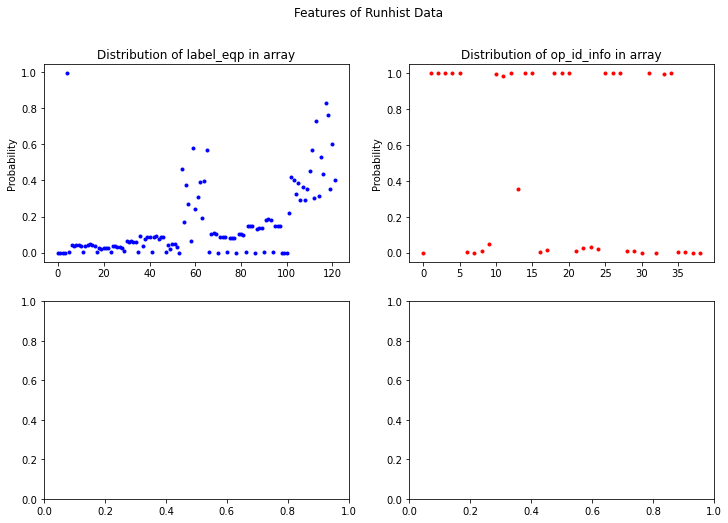

In [243]:
##### plot distribution of features #####
feature_distribution(array_all)

counts of equipment: 123 
counts of operation: 23 
counts of rework: 15


[Text(0.5, 1.0, '# Reworks in Instances'), Text(0.5, 0, '# Reworks')]

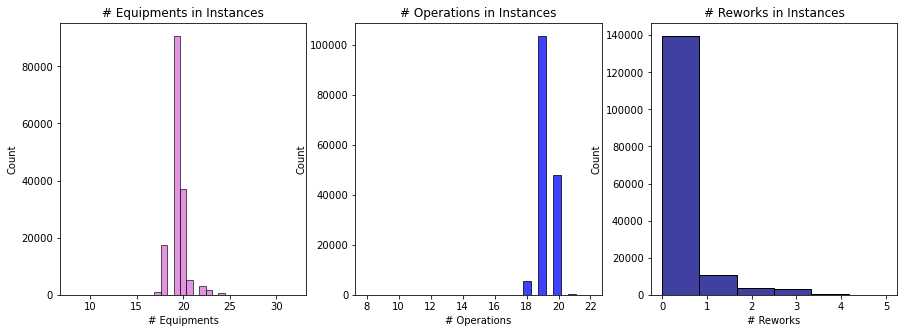

In [244]:
#### counts of equipment & operation used in each instances #####
target_data = array_train

allcols = target_data.columns.to_list()
allcols = allcols[1:-1]
eqp_list, op_list, rework_list = count_rework(allcols)

rework_mean = target_data[rework_list].apply(sum, axis = 1)
op_mean = target_data[op_list].apply(sum, axis = 1)
eqp_mean = target_data[eqp_list].apply(sum, axis = 1)

fig, axs = plt.subplots(ncols = 3, figsize = (15, 5))
ax = sns.histplot(eqp_mean, bins = 35, color = 'orchid', ax = axs[0])
ax.set(title = '# Equipments in Instances', xlabel = '# Equipments')
ax = sns.histplot(op_mean, bins = 30, color = 'blue', ax = axs[1])
ax.set(title = '# Operations in Instances', xlabel = '# Operations')
ax = sns.histplot(rework_mean, bins = 6, color = 'navy', ax = axs[2])
ax.set(title = '# Reworks in Instances', xlabel = '# Reworks')

counts of equipment: 106 
counts of operation: 3 
counts of rework: 8
counts of equipment: 106 
counts of operation: 3 
counts of rework: 8
counts of equipment: 106 
counts of operation: 3 
counts of rework: 8


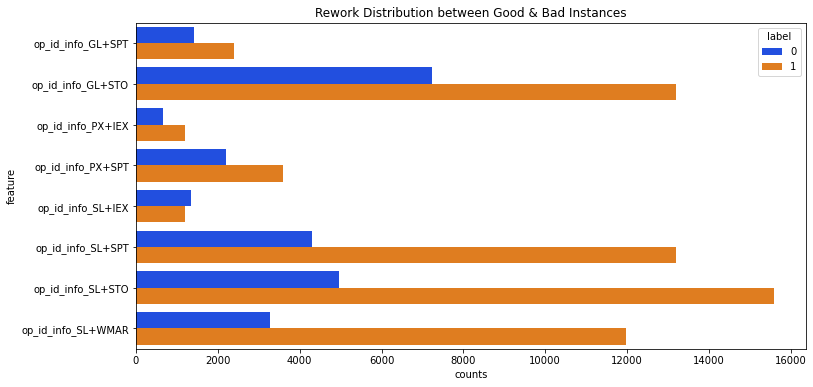

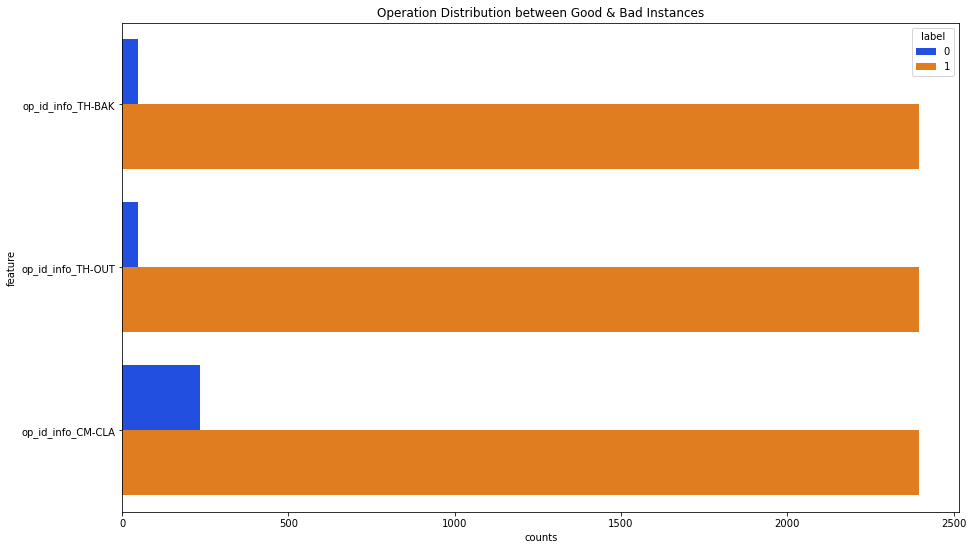

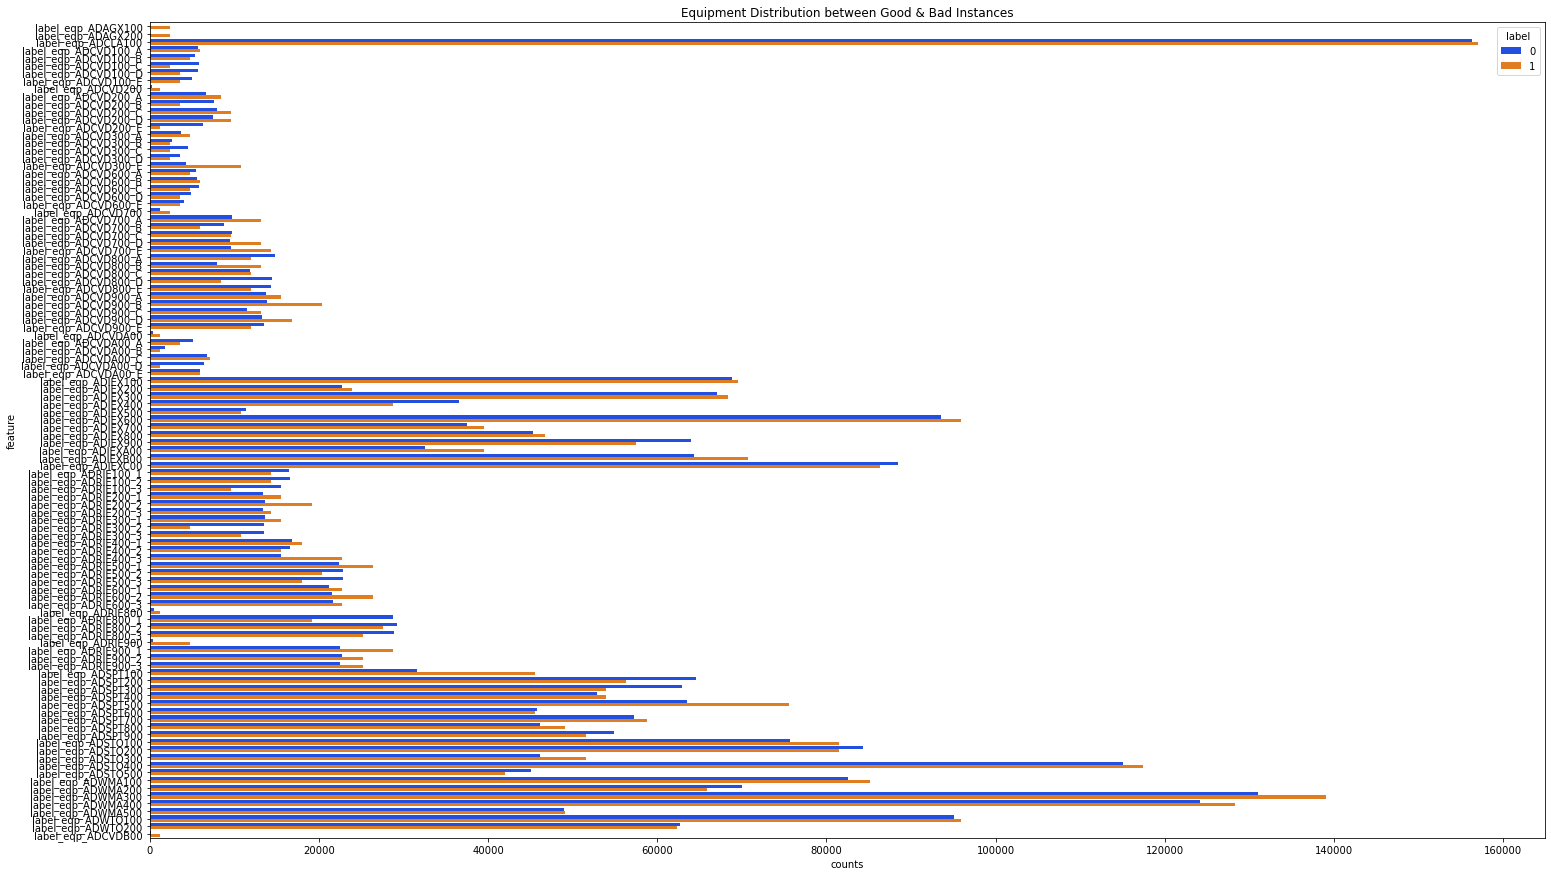

In [264]:
##### plot and compare the rework frequency in good & bad instances #####
array_target = array_train

bar_rework = feature_gb(array_target, target = 'Rework', figsize = (12, 6))
# bar_rework.set(xlim = (0, 250)) # zoom in to examine extremely low frequency rework 

bar_op = feature_gb(array_target, target = 'Operation', figsize = (15, 9))
# bar_op.set(xlim = (0, 2500)) 

bar_eqp = feature_gb(array_target, target = 'Equipment', figsize = (25, 15))

#### Apriori

In [248]:
##### apriori between equipments & reworks #####
# select features
target_data = array_train

# convert to boolean datatype
data_dim = apriori_data.shape
bool_vector = [bool(x) for x in np.array(apriori_data).flatten()]
bool_data = np.reshape(bool_vector, data_dim)

# inverse the dataframe to list reconize by apyori module
te = TransactionEncoder()
te.columns_ = apriori_data.columns
te_data = te.inverse_transform(bool_data)

In [249]:
##### association rules #####
association_rules = apriori(te_data, min_support = 0.001, min_confidence = 0.2, min_lift = 3, max_length = 2) 
association_results = list(association_rules)

asso_dict = {}
asso_frame = pd.DataFrame()
for item in association_results:
    pair = item[0] 
    items = [x for x in pair]
    asso_dict['Feature_1'] = items[0]
    asso_dict['Feature_2'] = items[1]
#     if len(items) > 2 :
#         asso_dict['Feature_3'] = items[2]
    asso_dict['Support'] = str(item[1])
    asso_dict['Confidence'] = str(item[2][0][2])
    asso_dict['Lift'] = str(item[2][0][3])
    asso_series = pd.Series(asso_dict)
    asso_frame = pd.concat([asso_frame, asso_series], axis = 1)
asso_frame = asso_frame.T.reset_index(drop = True)
asso_frame

,Feature_1,Feature_2,Support,Confidence,Lift
0,op_id_info_GL+STO,op_id_info_GL+SPT,0.004581755703331318,0.5031446540880503,10.923827945104541
1,op_id_info_SL+IEX,op_id_info_SL+STO,0.0085144293486907,0.9985074626865672,31.48283612036128
2,op_id_info_SL+SPT,op_id_info_SL+STO,0.021165165929555505,0.7718728243211881,24.337069618369405
3,op_id_info_SL+WMAR,op_id_info_SL+SPT,0.02093607814438894,0.7635182176839173,36.469018333720115
4,op_id_info_SL+WMAR,op_id_info_SL+STO,0.02093607814438894,0.6601123595505618,31.529895666131623
5,op_id_info_TH+IEX,op_id_info_TH+STO,0.008011708931241847,1.0,109.58507670850767


#### chamber issue

Text(0.5, 1.0, 'Bad Counts in Each Machine')

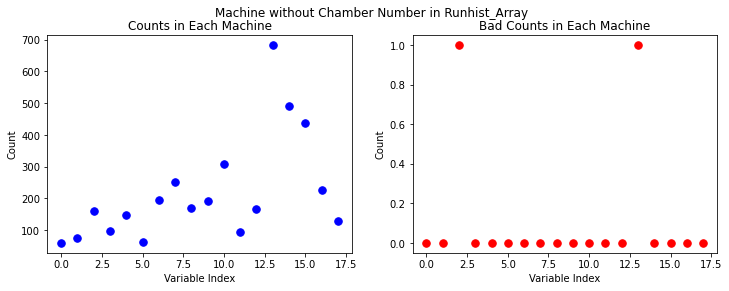

In [27]:
##### for machine without chamber number (m8-m3) #####
target_data = all_runhist

no_number = ['ADRIE100', 'ADRIE200', 'ADRIE300', 'ADRIE400', 'ADRIE500', 'ADRIE600', 'ADRIE800', 'ADRIE900', 'ADRIEA00']
no_number2 = ['ADCVD100', 'ADCVD200', 'ADCVD300', 'ADCVD600', 'ADCVD700', 'ADCVD800', 'ADCVD900', 'ADCVDA00', 'ADCVDB00']
no_number.extend(no_number2)
col_target = ['label_eqp_' + x for x in no_number]

runhist_chamber = target_data[col_target]
bad_count = runhist_chamber.apply(lambda x : sum(x*target_data.GB), axis = 0)
chamber_mean = runhist_chamber.apply(np.sum, axis = 0)

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
fig.suptitle('Machine without Chamber Number in Runhist_Array')
axs[0].plot(range(len(chamber_mean)), chamber_mean, 'b.', markersize = 15)
axs[0].set_xlabel('Variable Index')
axs[0].set_ylabel('Count')
axs[0].set_title('Counts in Each Machine')
axs[1].plot(range(len(bad_count)), bad_count, 'r.', markersize = 15)
axs[1].set_xlabel('Variable Index')
axs[1].set_ylabel('Count')
axs[1].set_title('Bad Counts in Each Machine')

### plot distance

In [ ]:
##### bad counts in module in each month #####
##### for the heatmap #####
GB_inner_m8_m1 = module.merge(array_old['id'], on = 'id', how = 'inner')
date_m8_m1 = GB_inner_m8_m1.shift_date.str.split('/', expand = True).astype(int)
date_m8_m1.columns = ['month', 'day', 'year']

GB_inner_m2_m7 = module_m2_m7.merge(all_array['id'], on = 'id', how = 'inner')
date_m2_m7 = GB_inner_m2_m7.shift_date.str.split('-', expand = True).astype(int)
date_m2_m7.columns = ['year', 'month', 'day']

bad_counts = []
all_month = list(range(8, 13)) + list(range(1, 8))
for index, months in enumerate(all_month) :
    if index < 6 :
        month_index = np.logical_and(GB_inner_m8_m1.GB == 1, date_m8_m1.month == months)
        length = len(GB_inner_m8_m1[month_index])
    else :
        month_index = np.logical_and(GB_inner_m2_m7.GB == 1, date_m2_m7.month == months)
        length = len(GB_inner_m2_m7[month_index])
    
    bad_counts.append(length)
# all bad_counts = [8, 12, 13, 8, 17, 7, 31, 46, 54, 51, 7, 37]

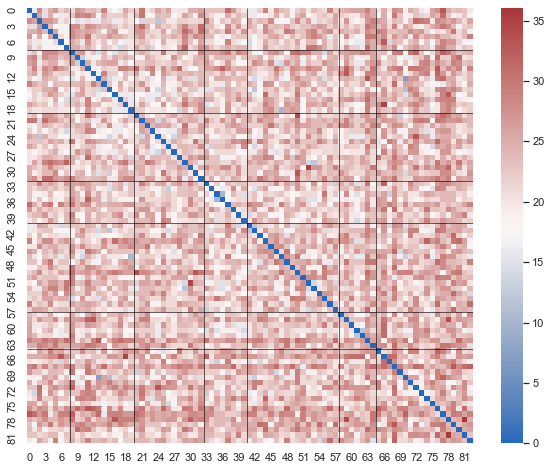

In [29]:
##### cauculate distance between bad instances #####
bad_counts = [8, 12, 13, 8, 17, 7, 31, 46, 54, 51, 7, 37]
distance_heatmap(all_runhist, bad_counts)

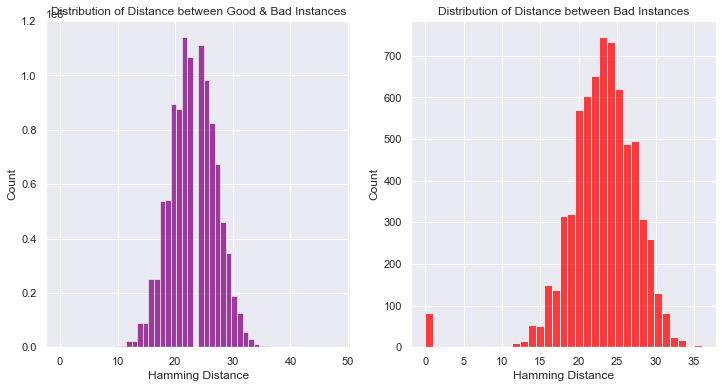

In [52]:
##### plot distance between instances #####
distance_histogram(all_runhist, bin1 = 40, bin2 = 35)

### bad types

In [289]:
run_bad_types = Bad_Type_def(array_test)
#run_bad_types.to_csv('run_bad_types.csv')

Number of Bad: 51
Types of Bad: 51 

